In [1]:
PATH = "/media/maxine/c8f4bcb2-c1fe-4676-877d-8e476418f5e5/0-RPE-cell-timelapse/"
from modules.learning.models import *
from modules.learning.train import train_model
from modules.utils import hc
from modules.visualize import plot_loss, plot_normalized_time_error

# from modules.learning.evaluate import Evaluation, get_latent_space, plot_umap
from matplotlib import pyplot as plt
from modules.learning.dycep_vit import DYCEP2
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# enet = EfficientNet()


track_path = PATH + "track_datasets/control_mm/train/images/"
label_path = PATH + "track_datasets/control_mm/train/labels/"
embeddings_path = PATH + "track_datasets/control_mm/train/embeddings/"

in_channels = [1]

expandable_segments:True


# training mamba model

In [2]:
model = DYCEP2()
model.to(DEVICE)

#########
# test on one track
#########

track_name = "0607.1629.npy"
# getting one sequence to check the model
imgs = torch.tensor(
    np.load(track_path + track_name, allow_pickle=True),
    dtype=torch.float32,
)[:, in_channels, :, :]


label = torch.tensor(
    np.load(label_path + track_name).reshape(2, -1).T,
    dtype=torch.float32,
)

emb = torch.tensor(
    np.load(embeddings_path + track_name),
    dtype=torch.float32,
)

print(emb.shape)

imgs, label, emb = imgs.to(DEVICE), label.to(DEVICE), emb.to(DEVICE)

zz = model.forward(emb[None, :, :])
# zz = zz.detach().cpu().numpy().squeeze()
# plt.plot(zz)
# print("min max")
# print(zz.min(0), zz.max(0))
# print(hc(model), "Parameters")
zz.shape

torch.Size([228, 768])


torch.Size([1, 228, 2])

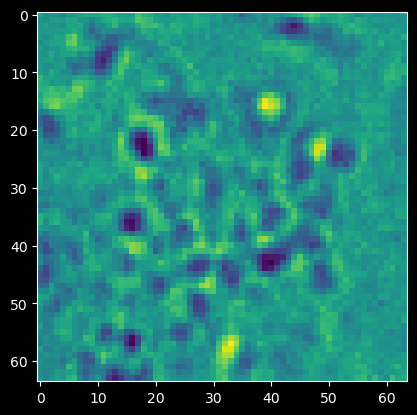

In [3]:
imgs.shape
imgs = torch.tensor(
    np.load(track_path + track_name, allow_pickle=True),
    dtype=torch.float32,
)[:, :, :, :]

plt.imshow(imgs[10, 1, :, :].detach().cpu().numpy())

In [ ]:
train_model(
    directory=PATH + "track_datasets/control_mm/",
    model=model,
    # pass [1] for only BF channel, or [1,1,1] for 3 times the same channel
    # or [0,1,2] for all channels
    img_channels=in_channels,
    batch_size=5,
    learning_rate=1e-5,
    slice_p=0.5,
    slice_len=20,
    random_len=True,
    name="DYCEP",
    num_epochs=1,
)

Epoch 1/1


ERROR:tornado.general:SEND Error: Host unreachable


# Example to swap temporal encoders

In [2]:
from modules.learning.time_encoders.transformer import SmallTransformerEncoder
from torch import nn

in_channels = [1]

temporal_encoder_dim = 256

temporal_encoder_n_layers = 6
transformer_n_layers = 5

torch_transformer_temporal_encoder = nn.TransformerEncoder(
    nn.TransformerEncoderLayer(
        d_model=temporal_encoder_dim,
        nhead=8,
        dim_feedforward=temporal_encoder_dim * 2,
        batch_first=True,
    ),
    num_layers=transformer_n_layers,
)
transformer_temporal_encoder = SmallTransformerEncoder(
    d_model=temporal_encoder_dim, num_layers=temporal_encoder_n_layers
)

lstm_temporal_encoder = nn.LSTM(
        input_size=temporal_encoder_dim,
        hidden_size=temporal_encoder_dim,
        num_layers=temporal_encoder_n_layers,
        batch_first=True,
        bidirectional=False,
    )


In [3]:
model = DYCEP(
    cnn_in_channels=len(in_channels),
    mamba_z_dim=temporal_encoder_dim,
    mamba_n_layers=temporal_encoder_n_layers,
)
model_transformer = DYCEP(
    cnn_in_channels=len(in_channels), temporal_encoder=transformer_temporal_encoder
)

model_torch_transformer = DYCEP(
    cnn_in_channels=len(in_channels),
    temporal_encoder=torch_transformer_temporal_encoder,
)

model_lstm = DYCEP(
    cnn_in_channels=len(in_channels), temporal_encoder=lstm_temporal_encoder
)

In [4]:
from modules.utils import hc

print(f"transformer model has {hc(model_torch_transformer)} parameters")
print(f"lstm model has {hc(model_lstm)} parameters")
print(f"mamba model has {hc(model)} parameters")

transformer model has 3.31M parameters
lstm model has 3.83M parameters
mamba model has 3.30M parameters


In [ ]:
train_model(
    directory=PATH + "track_datasets/control_mm/",
    model=model_lstm,
    # pass [1] for only BF channel, or [1,1,1] for 3 times the same channel
    # or [0,1,2] for all channels
    img_channels=in_channels,
    batch_size=5,
    learning_rate=1e-4,
    slice_p=0.0,
    slice_len=20,
    random_len=True,
    name="DYCEP",
    num_epochs=2,
)

Epoch 1/2


100%|██████████| 72/72 [00:04<00:00, 14.87it/s]


    Train Loss: 0.100, Test Loss: 0.064
    Train R2: -0.175, Test R2: 0.256
Epoch 2/2


100%|██████████| 72/72 [00:04<00:00, 14.67it/s]

    Train Loss: 0.054, Test Loss: 0.050
    Train R2: 0.353, Test R2: 0.426


'Done!'

: 

In [6]:
model.temporal_encoder.type

# get method name from model.temporal_encode
type(model_torch_transformer.temporal_encoder.__class__.__name__)

str

In [19]:
import datetime

def format_date_yyyymmddhhmm(datetime_obj):
  """
  Formats a datetime object into a string with the format YYYYMMDDHHMM.

  Args:
    datetime_obj: A datetime.datetime object.

  Returns:
    A string representing the date and time in YYYYMMDDHHMM format.
  """
  return datetime_obj.strftime("%Y_%m_%d_%H_%M")

# Example usage:
now = datetime.datetime.now()
formatted_datetime = format_date_yyyymmddhhmm(now)
print(f"Current date and time in YYYYMMDDHHMM format: {formatted_datetime}")




Current date and time in YYYYMMDDHHMM format: 2025_01_07_16_32


# Go to result_dycep notebook